#Date: 29-10-2025

#Lab-3 Assignment

#Name: Chittimalla Pujitha

#HTNO: 2503B05118

#Mtech - 1st year

In [12]:
import pandas as pd
import numpy as np

data = pd.DataFrame({
    'Age': [70, 65, 60, 55, 45, 40, 35, 30],
    'Treated': [1, 1, 1, 1, 0, 0, 0, 0],
    'BP': [120, 118, 115, 117, 122, 125, 126, 124],
    'Propensity': [0.9, 0.85, 0.75, 0.6, 0.4, 0.25, 0.2, 0.1]
})

# Compute weights
data['Weight'] = np.where(data['Treated'] == 1, 1 / data['Propensity'], 1 / (1 - data['Propensity']))

# Weighted averages
treated = np.average(data.loc[data['Treated'] == 1, 'BP'], weights=data.loc[data['Treated'] == 1, 'Weight'])
control = np.average(data.loc[data['Treated'] == 0, 'BP'], weights=data.loc[data['Treated'] == 0, 'Weight'])

print("Weighted BP (Treated):", round(treated, 2))
print("Weighted BP (Control):", round(control, 2))

print("Treatment Effect (Bias Corrected):", round(treated - control, 2))

Weighted BP (Treated): 117.35
Weighted BP (Control): 124.09
Treatment Effect (Bias Corrected): -6.74


In [13]:
import pandas as pd
import numpy as np
import os

file_path=r"/content/titanic3.xls"

df=pd.read_excel(file_path,engine="xlrd")

cols=["survived","pclass","sex","age","fare","embarked"]
df=df[cols].dropna().copy()

df["treated"]=(df["pclass"]==1).astype(int)
x_cols=["sex","age","fare","embarked"]
y_col="survived"
print(" Data loaded:",df.shape)
df.head()

 Data loaded: (1043, 7)


survived  pclass     sex      age      fare embarked  treated
0         1       1  female  29.0000  211.3375        S        1
1         1       1    male   0.9167  151.5500        S        1
2         0       1  female   2.0000  151.5500        S        1
3         0       1    male  30.0000  151.5500        S        1
4         0       1  female  25.0000  151.5500        S        1

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

X = df[x_cols]
T = df["treated"].astype(int)

# Preprocess: one hot for categoricals, scale numerics
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), ["sex", "embarked"]),
        ("num", StandardScaler(), ["age", "fare"])
    ],
    remainder="drop"
)

logit = LogisticRegression(max_iter=2000, solver="lbfgs")
ps_model = Pipeline([("prep", preprocess), ("logit", logit)])

ps_model.fit(X, T)

df["propensity"] = ps_model.predict_proba(X)[:, 1]

print("Propensity AUC (discrimination of T):", round(roc_auc_score(T, df["propensity"]), 3))

display(df[["treated", "propensity"]].head(10))

Propensity AUC (discrimination of T): 0.97


treated  propensity
0        1    0.999999
1        1    0.998559
2        1    0.998352
3        1    0.999884
4        1    0.999775
5        1    0.372368
6        1    0.994112
7        1    0.024916
8        1    0.870315
9        1    0.993141

2. Basic IPW

In [15]:
# Basic IPW
w_basic = np.where(T == 1, 1.0 / df["propensity"], 1.0 / (1.0 - df["propensity"]))

# Stabilized IPW: multiply by marginal P(Treated) to reduce variance
P_t = T.mean()

w_stab = np.where(T == 1, P_t / df["propensity"], (1 - P_t) / (1.0 - df["propensity"]))

# Optionally clip extreme weights for stability (common in practice)
clip_lo, clip_hi = 0.1, 10.0

w_clip = np.clip(w_stab, clip_lo, clip_hi)

df["w_basic"] = w_basic
df["w_stab"] = w_stab
df["w_clip"] = w_clip

display(df[["treated", "propensity", "w_basic", "w_stab", "w_clip"]].head(10))

treated  propensity    w_basic     w_stab     w_clip
0        1    0.999999   1.000001   0.270374   0.270374
1        1    0.998559   1.001443   0.270764   0.270764
2        1    0.998352   1.001651   0.270820   0.270820
3        1    0.999884   1.000116   0.270405   0.270405
4        1    0.999775   1.000225   0.270435   0.270435
5        1    0.372368   2.685519   0.726094   0.726094
6        1    0.994112   1.005923   0.271975   0.271975
7        1    0.024916  40.134849  10.851417  10.000000
8        1    0.870315   1.149009   0.310662   0.310662
9        1    0.993141   1.006907   0.272241   0.272241

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
X = df[x_cols]
T= df["treated"].astype(int)
#Preprocess: one hot for categoricals, scate numerics
preprocess=ColumnTransformer(
      transformers=[
      ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), ["sex", "embarked"]),
      ("num", StandardScaler(), ["age", "fare"]),
      ],
      remainder="drop"
  )

logit=LogisticRegression(max_iter=2000, solver="lbfgs")

ps_model=Pipeline([("prep", preprocess), ("logit", logit)])
ps_model.fit(X, T)
df["propensity"]= ps_model.predict_proba(X)[:, 1]

print("Propensity AUC (discrimination of T):", round(roc_auc_score(T, df["propensity"]), 3))

df[["treated", "propensity"]].head(10)

Propensity AUC (discrimination of T): 0.97


treated  propensity
0        1    0.999999
1        1    0.998559
2        1    0.998352
3        1    0.999884
4        1    0.999775
5        1    0.372368
6        1    0.994112
7        1    0.024916
8        1    0.870315
9        1    0.993141

4) Overlap check (distributions of propensity by group)

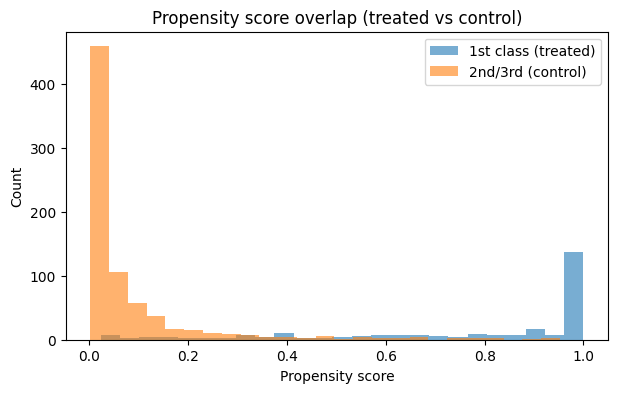

Propensity range: 0.00204 to 1.0


In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(df.loc[df["treated"] == 1, "propensity"], bins=25, alpha=0.6, label="1st class (treated)")
plt.hist(df.loc[df["treated"] == 0, "propensity"], bins=25, alpha=0.6, label="2nd/3rd (control)")
plt.xlabel("Propensity score")
plt.ylabel("Count")
plt.title("Propensity score overlap (treated vs control)")
plt.legend()
plt.show()

print("Propensity range:",
round(df["propensity"].min(),5), "to", round(df["propensity"].max(),3))

5) Covariate balance (Standardized Mean Differences) before vs after IPW

In [18]:
def weighted_mean_var(x, w):
    # Calculate weighted mean and variance
    # Ensure weights sum to a non-zero value to avoid division by zero
    sum_w = np.sum(w)
    if sum_w == 0:
        return np.nan, np.nan # Handle cases where weights are all zero

    mean = np.sum(x * w) / sum_w
    # Calculate weighted variance (using sample variance formula)
    variance = np.sum(w * (x - mean)**2) / (sum_w * (len(x) - 1) / len(x)) # Bessel's correction
    return mean, variance

def smd_unweighted(x, t):
    # Calculate Standardized Mean Difference (SMD) for unweighted data
    x1 = x[t == 1]
    x0 = x[t == 0]
    mean1, var1 = np.mean(x1), np.var(x1, ddof=1) # use ddof=1 for sample variance
    mean0, var0 = np.mean(x0), np.var(x0, ddof=1)
    sp = np.sqrt(((len(x1)-1)*var1 + (len(x0)-1)*var0) / (len(x1) + len(x0) - 2)) # Pooled standard deviation
    return (mean1 - mean0) / sp if sp else 0.0 # Avoid division by zero

def smd_weighted(x, t, w):
    # Calculate Standardized Mean Difference (SMD) for weighted data
    x1, w1 = x[t == 1], w[t == 1]
    x0, w0 = x[t == 0], w[t == 0]
    mean1, var1 = weighted_mean_var(x1, w1)
    mean0, var0 = weighted_mean_var(x0, w0)
    sp = np.sqrt((var1 + var0) / 2.0) # Pooled standard deviation for weighted data
    return (mean1 - mean0) / sp if sp else 0.0 # Avoid division by zero


num_cols = ["age", "fare"] # numeric covariates to check balance
bal = []
for col in num_cols:
    x = df[col].values
    t = df["treated"].values
    w_stab = df["w_stab"].values
    w_clip = df["w_clip"].values

    bal.append({
        "covariate": col,
        "SMD unweighted": round(smd_unweighted(x, t), 3),
        "SMD stabilized": round(smd_weighted(x, t, w_stab), 3),
        "SMD clipped": round(smd_weighted(x, t, w_clip), 3)
    })

pd.DataFrame(bal)

covariate  SMD unweighted  SMD stabilized  SMD clipped
0       age           0.961           0.564        0.578
1      fare           1.725           0.576        0.606